This example shows how to analyze and visualize results after running the $\it pyGWBSE$ workflow. You need to first run the 'create_workflow.ipynb' example to create and run the workflows and then you can run this example. All the output results are automatically stored by $\it pyGWBSE$ in the GW-BSE database so this example needs to access the database to run. 

Let's start by loading the required libraries, 

In [1]:
from pymongo import MongoClient
import matplotlib.pyplot as plt
import numpy as np

We have to specify details of the database we have used earlier to create and run the $\it pyGWBSE$ workflow

In [2]:
hostname='hydrogen.cmd.lab.asu.edu'
port=27017
username='tbiswas3'
password='CMD##tatha'
dbname='debug_db'

Now we can connect to the database using pymongo

In [3]:
client = MongoClient(hostname, port)
db = client[dbname]
db.authenticate(username, password)

True

First let's analyze the results for AlN workflow. As you might remember "mp-661" has been used as identifier for AlN in the database when we created the workflow earlier using 'create_workflow.ipynb'.

In [4]:
mid='mp-661'

Let's check how the convergence calculation went 

In [5]:
eqpcollection = db.get_collection('QP_Results')
for x in eqpcollection.find({'material_id': mid, "task_label": { "$regex": 'Convergence'}}):
    tl=x["task_label"]
    nbands=x["incar"]["NBANDS"]
    gap=x["indirect_gap"]
    ifconv=x['ifconv']
    print(tl, nbands, '%5.2f' %gap, ifconv)

Convergence_Iteration: 1 39  5.48 False
Convergence_Iteration: 2 65  5.54 True


As you can see the workflow computed QP gap using NBANDS value of 39 and 65 and found that the gap didn't change by more than 0.1. As a result the Firework set 'ifconv' tag to True and stopped. 

We can also check what was the effect of partial self-consistent iterations on the QP gap

In [6]:
eqpcollection = db.get_collection('QP_Results')
for x in eqpcollection.find({'material_id': mid, "task_label": { "$regex": 'scGW'}}):
    tl=x["task_label"]
    gap=x["indirect_gap"]
    ifconv=x['ifconv']
    print(tl, nbands, '%5.2f' %gap, ifconv)

scGW_Iteration: 1 65  5.54 False
scGW_Iteration: 2 65  6.03 False
scGW_Iteration: 3 65  6.18 False
scGW_Iteration: 4 65  6.23 True


As you can see the workflow continued the partial self-consistent (GW$_0$) calculation untill the QP gap is converged within 0.1 eV. After that the Firework set 'ifconv' tag to True and stopped. The QP gap of AlN at the G$_0$W$_0$ level turns out to be 5.54 eV and it is 6.23 eV at the GW$_0$ level.

Now let's retrieve the data to plot DFT bandstructure computed by VASP and compare it with WANNIER extrapolated bandstructure. 

In [7]:
collection = db.get_collection('WANNIER_Results')
for x in collection.find({'task_label' : "CHECK_WANNIER_INTERPOLATION", 'material_id' : mid}):
    kpts=np.array(x["wannier_kpoints"]) 
    #x coordinates of energy values to plot bandstructure
    eigs_wann=np.array(x["wannier_eigenvalues"]) 
    #wannier interpolated energies to plot bandstructure
    eigs_vasp=np.transpose(np.array(x["actual_eigenvalues"])) 
    #vasp computed energies to plot bandstructure 
    spkptls=x["special_kpoint_labels"] 
    #labels of special k-points in the bandstructure    
    spkptcs=x["special_kpoint_coordinates"] 
    #x coordinates of special  k-points in the bandstructure 

Here is generic function to plot the bandstructure  

In [8]:
def plot_bandstructure(kpts,eigs,spkptls,spkptcs,cl,lb):
    
    """
    kpts: 1-D array of x coordinates of energy values to plot bandstructure
    eigs: 2-D array (band index, k-point index) of energies to plot bandstructure 
    spkptls: 1-D array of labels of special k-points in the bandstructure 
    spkptcs: 1-D array of x coordinates of special k-points in the bandstructure 
    """
    
    nb=np.shape(eigs)[0]
    for j in range(nb):
        if j==0:
            plt.plot(kpts,eigs[j,:],c=cl,lw=2,label=lb)
        else:
            plt.plot(kpts,eigs[j,:],c=cl,lw=2)
    for spkptc in spkptcs:
        plt.axvline(spkptc,lw=2,c='k')
    plt.ylabel(r'E-E$_{VBM}$',fontsize=15)
    plt.xticks(spkptcs, spkptls ,fontsize=15)
    plt.xlim(spkptcs[0],max(spkptcs))

We need to format special characters like $\Gamma$ for matplotlib 

In [9]:
print(spkptls)
spkptls = [r'$\Gamma$' if item == '\\GAMMA' else item for item in spkptls]
print(spkptls)

['\\GAMMA', 'M', 'K', '\\GAMMA', 'A', 'L', 'H', 'A|L', 'M|K', 'H']
['$\\Gamma$', 'M', 'K', '$\\Gamma$', 'A', 'L', 'H', 'A|L', 'M|K', 'H']


Now let's use plot_bandstructure function to check how good the wannier interpolation is 

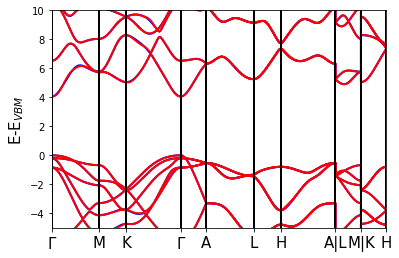

In [10]:
plot_bandstructure(kpts[0,:],eigs_vasp,spkptls,spkptcs,'b','VASP')
plot_bandstructure(kpts[0,:],eigs_wann,spkptls,spkptcs,'r','WANNIER')
plt.ylim(-5,10)
plt.show()

Now let's retrieve the wannier interpolated QP energies to plot GW bandstructure 

In [11]:
collection = db.get_collection('WANNIER_Results')
for x in collection.find({'task_label' : "GW_BANDSTRUCTURE", 'material_id' : mid}):
    eigs_gw=np.array(x["wannier_eigenvalues"]) #wannier interpolated QP energies to plot GW bandstructure

Let's use the plot_bandstructure function and compare the DFT vs GW bandstructure

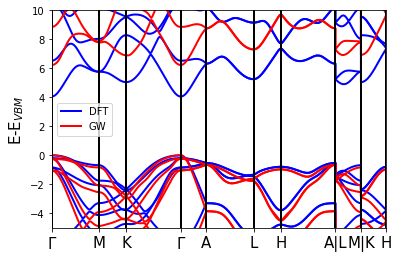

In [12]:
plot_bandstructure(kpts[0,:],eigs_vasp,spkptls,spkptcs,'b','DFT')
plot_bandstructure(kpts[0,:],eigs_gw,spkptls,spkptcs,'r','GW')
plt.ylim(-5,10)
plt.legend()
plt.show()

Now let's retrieve the projections of KS orbitals on atomic orbitals which can be used to plot orbital resolved DOS (PDOS)

In [13]:
eqpcollection = db.get_collection('EPS_Results')
for x in eqpcollection.find({"material_id": mid}):
    proj_eig=x["projected_eigs"] #projections of KS orbitals on atomic orbitals
    eigs=x["ks_energies"] #KS energies  
    vbm=x["vbm"] #VBM
    kwg=x["kpoint_weights"] #weights of symmetry reduced k-points

    
#This was a non spin polarized calculation so there is only one spin index
for spin, v in proj_eig.items():
    peig=np.array(v)

for spin, v in eigs.items():
    eig=np.array(v)

#setting the VBM as zero in energy axis
eig=np.array(eig)-vbm

In [14]:
#First we need to define functions to compute PDOS from projections

#Gaussian Function
def gaussian(x,x0,sigma):
    y = (1 / sigma*np.sqrt(2 * np.pi)) * np.exp(-((x-x0)/sigma) ** 2 / 2.)
    return y

#Function to compute PDOS from projections

def calc_pdos(ias,ios,peig,eig,kwg,enmin,enmax,n,sigma):
    """
    
    Args:
    
    ias: list of atom indices to be included in PDOS
    ios: list of orbital indices to be included in PDOS
    peig: 4-D array (k-point index, band_index, atom_index, orbital_index) 
            contaning projections of KS wavefunctions on atomic oritals
    eig: 2-D array (k-point index, band index) of energy eigenvalues
    kwg: 1-D array of k-point weights
    enmin: minimum of the energy window to plot PDOS
    enmax: maximum of the energy window to plot PDOS
    n: number of energy values to be used in PDOS 
    sigma: width of the Gaussian smearing 
    
    Returns:
    
    x: energy values 
    y: PDOS  
    t: total DOS
    
    """
    nk=np.shape(peig)[0]
    nb=np.shape(peig)[1]
    na=np.shape(peig)[2]
    no=np.shape(peig)[3]
    ens=np.linspace(enmin,enmax,num=n)

    x=[]
    y=[]
    t=[]
    for en in ens:
        den=0
        ten=0
        for ik in range(nk):
            for ib in range(nb):
                eigv=eig[ik][ib][0]
                smr=gaussian(eigv,en,sigma)
                ten=ten+smr*kwg[ik]
                for ia in ias:
                    for io in ios:
                        den=den+peig[ik][ib][ia][io]*smr*kwg[ik]
        x.append(en)
        y.append(den/3.14)
        t.append(ten/3.14)
    return x,y,t

Now let's use the calc_pdos function we just defined to plot PDOS of N(p) states in AlN 

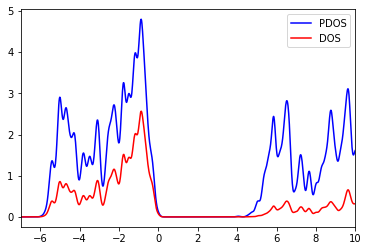

In [15]:
atoms_list=[2,3] #atom 2 and 3 are N
orbital_list=[1,2,3] # orbital 1,2,3 are p- orbitals

#Other paramters to compute PDOS

enmin=-7 
enmax=10
num=1000
sigma=0.1

#Compute PDOS and total DOS

en,tdos,pdos=calc_pdos(atoms_list,orbital_list,peig,eig,kwg,enmin,enmax,num,sigma)

#Now we can plot PDOS and total DOS

plt.plot(en,pdos,label='PDOS',c='b')
plt.plot(en,tdos,label='DOS',c='r')
plt.xlim(enmin,enmax)
plt.legend()
plt.show()

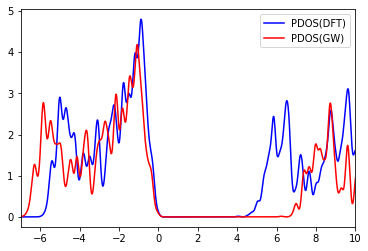

In [16]:
# We can also use QP energies instead of KS energies to plot QP DOS/PDOS 

#First let's retreive QP energies and QP VBM from the database

eqpcollection = db.get_collection('QP_Results')
for x in eqpcollection.find({'material_id': mid, "task_label": { "$regex": 'scGW'}, 'ifconv': True}):
    eigs_gw=x["qp_energies"]
    vbm_gw=x["vbm"]
    
for spin, v in eigs_gw.items():
    eig_gw=np.array(v)

#setting the VBM of QP energies as zero in energy axis
eig_gw=np.array(eig_gw)-vbm_gw

#Compute PDOS and DOS with QP correction 

en,tdos_gw,pdos_gw=calc_pdos(atoms_list,orbital_list,peig,eig_gw,kwg,enmin,enmax,num,sigma)

#Now we can plot PDOS and total DOS with and without QP correction  

plt.plot(en,pdos,label='PDOS(DFT)',c='b')
plt.plot(en,pdos_gw,label='PDOS(GW)',c='r')
#plt.plot(en,tdos,label='DOS(DFT)',c='k')
#plt.plot(en,tdos_gw,label='DOS(GW)',c='g')
plt.xlim(enmin,enmax)
plt.legend()
plt.show()

Now Let's look at the static dielectric tensor of AlN computed at the DFT level 

In [17]:
eqpcollection = db.get_collection('EPS_Results')
for x in eqpcollection.find({"material_id": mid}):
    dc=x['dielectric constant']
dc

[[4.609002, 0.0, 0.0], [0.0, 4.60900307, 0.0], [0.0, 0.0, 4.81528465]]

dielectric constant perpendicular to c-axis ($\epsilon^{\perp}_{\infty}$). Note that, because of hexagonal symmetry dc[0][0] and dc[1][1] is the equal. 

In [18]:
dc[0][0]

4.609002

dielectric constant parallel to c-axis ($\epsilon^{\parallel}_{\infty}$)

In [19]:
dc[2][2]

4.81528465

In [20]:
#Let's retrieve the effective masses of AlN

eqpcollection = db.get_collection('EMC_Results')
for x in eqpcollection.find({"material_id": mid}):
    hmass=x['hole_effective_mass']
    emass=x['electron_effective_mass']

'hmass' and 'emass' are the dictionaries containing hole and electron
effective masses respectively. The keys for each effective mass values 
are constructed as (ibnd,dir1,dir2) where, ibnd is the index of the 
band from which the effective mass is computed in the direction from 
special k-point dir1 to special k-point dir2. 

In [21]:
#hole effective masses 

for key, value in hmass.items():
    print(key, '%5.2f' %(value*-1))

emass1: 8, (\Gamma), (M)  4.32
emass2: 8, (\Gamma), (K)  4.32
emass3: 8, (\Gamma), (A)  0.24


In [22]:
#elctron effective masses 

for key, value in emass.items():
    print(key, '%5.2f' %value)

emass1: 9, (\Gamma), (M)  0.30
emass2: 9, (\Gamma), (K)  0.30
emass3: 9, (\Gamma), (A)  0.28


AlN has a hexagonal crystal structure. The VBM as well as the CBM is located at the $\Gamma$ point. Both the VBM (8$^{th}$ band) and CBM (9$^{th}$ band) in non-degenerate. From the bandstructure (computed earlier) we can see that there can be 3 special directions in the Brillouin zone along which the effective masses can be evaluated for the band edges. Which are, 

1. $\Gamma$ (0,0,0) $\rightarrow$ M (1/2,0,0)
2. $\Gamma$ (0,0,0) $\rightarrow$ K (1/3,1/3,0)
3. $\Gamma$ (0,0,0) $\rightarrow$ A (0,0,1/2)

First two directions are perpendicular to c-axis and will produce $m^{\perp}$ and the third is parallel to c-axis
and will produce $m^{\parallel}$

Now we will plot the absorption spectra of Silicon from the results stored by the second workflow in 'create_workflow.ipynb' example. We used 'Si_test' as the unique identifier for the Silicon example

In [23]:
mid='Si_test'

Now, let's retrieve the data to plot the absorption spectra and analyze results from BSE calculation 

In [24]:
eqpcollection = db.get_collection('BSE_Results')
for x in eqpcollection.find({"material_id": mid}):
    bfreq=x["frequency"] 
    #1-D array containing list of frequencies in eV
    beps1=x["epsilon_1"] 
    #Real part of the dielectric function at those frquencies
    beps2=x["epsilon_2"] 
    #Imaginary part of the dielectric function at those frquencies
    opt=x["optical_transition"] 
    #List of [en,os] where,en is the transition energies in eV and 
    #os is the corresponding oscillator strengths
    qpg=x["direct_gap"] #Direct QP gap

Each element of $beps1$ and $beps2$ contains six values which are ordered as $\epsilon^{xx}$, $\epsilon^{yy}$, $\epsilon^{zz}$, $\epsilon^{xy}$, $\epsilon^{yz}$, $\epsilon^{xz}$ 

In [25]:
beps2[0]

[0.0, 0.0, 0.0, -0.0, 0.0, -0.0]

Now let's compute the exciton binding energy of silicon 

In [26]:
opg=opt[0][0]
ebe=qpg-opg
print('Optical gap:','%5.2f' %opg, 'Exciton Binding Energy:','%5.2f' %ebe)

Optical gap:  3.05 Exciton Binding Energy:  0.09


Now let's extract the $\epsilon^{xx}_1$ and $\epsilon^{xx}_2$ from $beps1$ and $beps2$ and plot them.

In [27]:
beps1x=[row[0] for row in beps1]
beps2x=[row[0] for row in beps2]

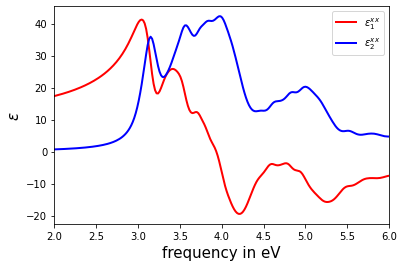

In [28]:
#Plot BSE absorption spectra

plt.plot(bfreq,beps1x,c='r',ls='-', lw=2,label=r'$\epsilon_1^{xx}$')
plt.plot(bfreq,beps2x,c='b',ls='-', lw=2,label=r'$\epsilon_2^{xx}$')
plt.xlabel('frequency in eV', fontsize=15)
plt.ylabel(r'$\epsilon$',fontsize=15)
plt.legend()
plt.xlim(2,6)
plt.show()

One might also be interested in looking at the RPA absorption spectra from the DFT level calculation which can be found in the 'RPA_Results' collection.

In [29]:
#Get data to plot the RPA absorption spectra

eqpcollection = db.get_collection('RPA_Results')
for x in eqpcollection.find({"material_id": mid}):
    rfreq=x["frequency"] 
    #1-D array containing list of frequencies in eV
    reps2=x["epsilon_2"] 
    #Imaginary part of the dielectric function at those frquencies
    

Now let's extract the $\epsilon^{xx}_2$ from $reps1$ and plot them.

In [30]:
reps2x=[row[0] for row in reps2]

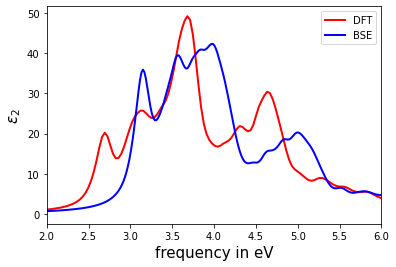

In [31]:
#Plot RPA absorption spectra and compare it with BSE 

plt.plot(rfreq,reps2x,c='r',ls='-', lw=2,label=r'DFT')
plt.plot(bfreq,beps2x,c='b',ls='-', lw=2,label=r'BSE')
plt.xlabel('frequency in eV', fontsize=15)
plt.ylabel(r'$\epsilon_2$',fontsize=15)
plt.legend()
plt.xlim(2,6)
plt.show()